In [1]:
import firebase_admin
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from firebase_admin import credentials, firestore
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Firebase Initialization
cred = credentials.Certificate("adminkey.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

# Constants
INCLUDE_ONLY = ['11111']
ACTIVITIES = ['sit', 'walk', 'upstairs']
TIME_START, TIME_END = 3000, 27000
SAMPLING_RATE = 100  # Hz
OVERLAP = 0.5
CHUNK_SIZE = 1  # of seconds
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.001
EMB_SIZE = 128
NHEAD = 8
NHID = 128
NLAYERS = 3
DROPOUT = 0.1

In [7]:
def fetch_data():
    """Fetch combined accelerometer + gyroscope data for patient"""
    data_raw, docs = [], []

    data_ref = db.collection("data")
    for treatment_doc in data_ref.stream():
        treatment_name = treatment_doc.id
        print(f"Treatment: {treatment_name}")

        for patient_id in INCLUDE_ONLY:
            print(f"  Patient: {patient_id}")
            subject_ref = data_ref.document(treatment_name).collection(patient_id)

            for activity in ACTIVITIES:
                activity_ref = subject_ref.document(activity)
                phone_location_col = activity_ref.collections()

                for phone_location in phone_location_col:
                    location_name = phone_location.id
                    print(f"    Activity: {activity}")
                    print(f"      Phone Location: {location_name}")

                    for recording in phone_location.stream():
                        record = recording.to_dict()
                        if 'acceleration' not in record:
                            print("        Skipped: No acceleration data")
                            continue

                        df = pd.DataFrame(record['acceleration'])

                        # Treat timestamps as relative within each recording since app reports weird timestamps
                        timestamps = df['timestamp']
                        min_time = timestamps.min()
                        max_time = timestamps.max()

                        # Exclude first and last 2.5 seconds
                        time_start_cutoff = min_time + 2500  # ms
                        time_end_cutoff = max_time - 2500    # ms

                        df = df[(timestamps >= time_start_cutoff) & (timestamps <= time_end_cutoff)]

                        if df.empty:
                            print("        Skipped: Empty after timestamp filter")
                            continue

                        # Build combined feature dataframe
                        combined = pd.DataFrame({
                            'ax': df['accelerometer'].apply(lambda x: x['x']),
                            'ay': df['accelerometer'].apply(lambda x: x['y']),
                            'az': df['accelerometer'].apply(lambda x: x['z']),
                            'gx': df['gyroscope'].apply(lambda x: x['x']),
                            'gy': df['gyroscope'].apply(lambda x: x['y']),
                            'gz': df['gyroscope'].apply(lambda x: x['z']),
                        })

                        data_raw.append(combined)
                        docs.append({'activity': activity})
    return data_raw, docs

def chunk_data_raw(data_raw, docs, chunk_size_sec, sampling_rate, overlap=OVERLAP):
    """Chunk combined data into overlapping windows with labels."""
    data, labels = [], []
    chunk_samples = int(chunk_size_sec * sampling_rate)
    step = int(chunk_samples * (1 - overlap))

    for i, df in enumerate(data_raw):
        for start in range(0, len(df) - chunk_samples + 1, step):
            chunk = df.iloc[start:start + chunk_samples]
            if len(chunk) == chunk_samples:
                data.append(chunk.values)
                labels.append(ACTIVITIES.index(docs[i]['activity']))
    return np.array(data), np.array(labels)

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout=0.1, maxlen=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(maxlen, emb_size)
        position = torch.arange(0, maxlen, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-math.log(10000.0) / emb_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [9]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=6, emb_size=EMB_SIZE, nhead=NHEAD, nhid=NHID, nlayers=NLAYERS, nclasses=len(ACTIVITIES), dropout=DROPOUT):
        super().__init__()
        self.embedding = nn.Linear(input_dim, emb_size)
        self.pos_encoder = PositionalEncoding(emb_size, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=nhead, dim_feedforward=nhid, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.classifier = nn.Linear(emb_size, nclasses)
        self.emb_size = emb_size

    def forward(self, x):
        x = self.embedding(x) * math.sqrt(self.emb_size)
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)
        x = self.classifier(x)
        return x

In [10]:
def train_and_evaluate():
    print("Fetching all data...")
    data_raw, docs = fetch_data()
    print(f"Total data entries: {len(data_raw)}")

    X_all, y_all = chunk_data_raw(data_raw, docs, CHUNK_SIZE, SAMPLING_RATE, OVERLAP)
    print(f"All chunks: {X_all.shape}, All labels: {y_all.shape}")

    X_train, X_val, y_train, y_val = train_test_split(
        X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
    )

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.long)

    train_ds = TensorDataset(X_train, y_train)
    val_ds = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TransformerClassifier().to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    train_losses, val_losses = [], []

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss, all_preds, all_labels = 0, [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item()
                all_preds.extend(preds.argmax(dim=1).cpu().numpy())
                all_labels.extend(yb.cpu().numpy())
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        scheduler.step()

        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    plt.figure(figsize=(10,6))
    plt.plot(range(1, EPOCHS+1), train_losses, label='Train Loss')
    plt.plot(range(1, EPOCHS+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\nClassification Report on Validation Set:")
    print(classification_report(all_labels, all_preds, target_names=ACTIVITIES))

    cm = confusion_matrix(all_labels, all_preds)
    correct_counts = np.diag(cm)
    total_per_class = cm.sum(axis=1)
    accuracy_per_class = (correct_counts / total_per_class) * 100
    yticklabels_with_acc = [f"{act} ({accuracy_per_class[i]:.1f}%)" for i, act in enumerate(ACTIVITIES)]

    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=ACTIVITIES, yticklabels=yticklabels_with_acc)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Transformer Model Confusion Matrix")
    plt.show()

Fetching all data...
Treatment: AfterTreatment
  Patient: 11111
    Activity: sit
      Phone Location: DominantWrist
    Activity: walk
      Phone Location: DominantWrist
    Activity: upstairs
      Phone Location: DominantWrist
Treatment: BeforeTreatment
  Patient: 11111
    Activity: sit
      Phone Location: DominantWrist
    Activity: walk
      Phone Location: DominantWrist
    Activity: upstairs
      Phone Location: DominantWrist
Total data entries: 6
All chunks: (437, 100, 6), All labels: (437,)


c:\users\yuanh\appdata\local\programs\python\python38\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/100 | Train Loss: 0.7607 | Val Loss: 0.4559
Epoch 2/100 | Train Loss: 0.4055 | Val Loss: 0.2982
Epoch 3/100 | Train Loss: 0.3413 | Val Loss: 0.3079
Epoch 4/100 | Train Loss: 0.3721 | Val Loss: 0.3941
Epoch 5/100 | Train Loss: 0.3001 | Val Loss: 0.2822
Epoch 6/100 | Train Loss: 0.2972 | Val Loss: 0.2441
Epoch 7/100 | Train Loss: 0.2734 | Val Loss: 0.2649
Epoch 8/100 | Train Loss: 0.2619 | Val Loss: 0.2086
Epoch 9/100 | Train Loss: 0.2031 | Val Loss: 0.2050
Epoch 10/100 | Train Loss: 0.1553 | Val Loss: 0.2176
Epoch 11/100 | Train Loss: 0.1265 | Val Loss: 0.2299
Epoch 12/100 | Train Loss: 0.1213 | Val Loss: 0.2149
Epoch 13/100 | Train Loss: 0.0733 | Val Loss: 0.2431
Epoch 14/100 | Train Loss: 0.0769 | Val Loss: 0.2410
Epoch 15/100 | Train Loss: 0.0599 | Val Loss: 0.3135
Epoch 16/100 | Train Loss: 0.1134 | Val Loss: 0.2452
Epoch 17/100 | Train Loss: 0.1017 | Val Loss: 0.3317
Epoch 18/100 | Train Loss: 0.0716 | Val Loss: 0.2766
Epoch 19/100 | Train Loss: 0.0885 | Val Loss: 0.2358
Ep

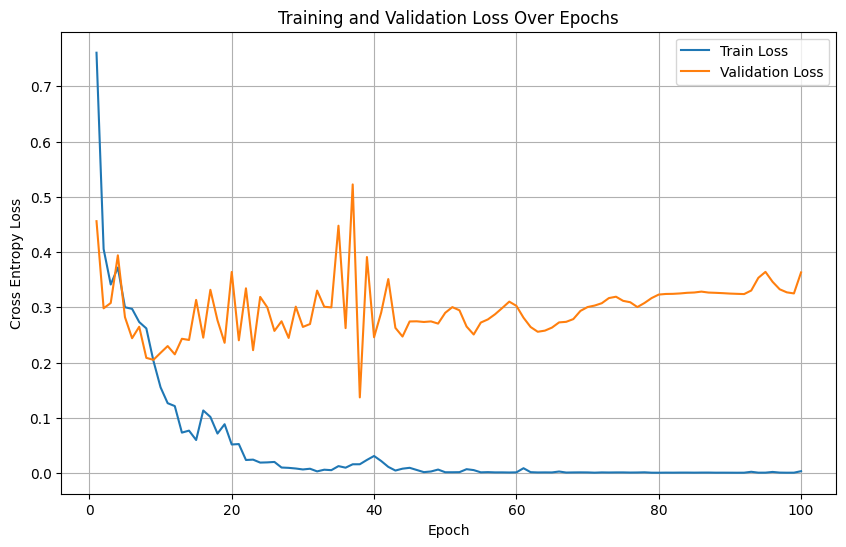


Classification Report on Validation Set:
              precision    recall  f1-score   support

         sit       1.00      1.00      1.00        20
        walk       0.91      0.97      0.94        40
    upstairs       0.96      0.86      0.91        28

    accuracy                           0.94        88
   macro avg       0.96      0.94      0.95        88
weighted avg       0.94      0.94      0.94        88



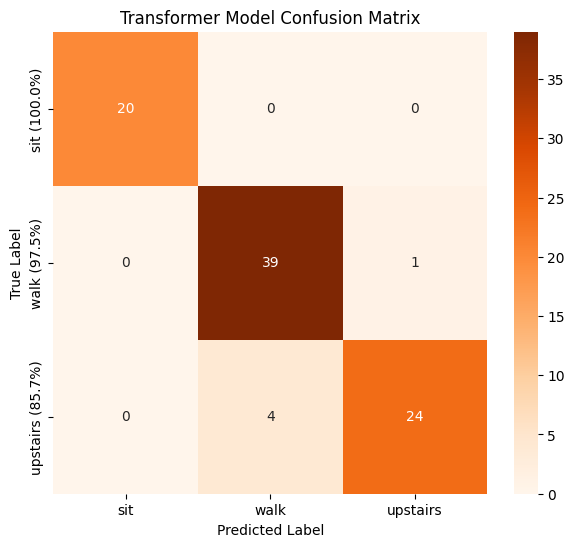

In [11]:
if __name__ == "__main__":
    train_and_evaluate()